 # Job Role Prediction: Final Model Training with XGBoost
 
 This is the definitive training notebook for our project. To achieve the highest possible accuracy, we are making two major upgrades:
 
 1.  **Using a More Powerful Algorithm**: We are replacing `RandomForestClassifier` with `XGBoost` (`XGBClassifier`), a state-of-the-art gradient boosting library known for its high performance and accuracy.
 2.  **Exhaustive Hyperparameter Tuning**: We will use a comprehensive parameter grid with 10-fold cross-validation (`cv=10`) to find the absolute best settings for our new model.
 
 ### Steps:
 1.  **Install XGBoost**: Ensure the library is installed.
 2.  **Load Data**: Import the final weighted dataset.
 3.  **Prepare & Split Data**: Standard preprocessing steps.
 4.  **Hyperparameter Tuning**: Run an extensive `GridSearchCV` on the `XGBClassifier`.
 5.  **Train & Evaluate Final Model**: Train the best model and analyze its performance.
 6.  **Save Model**: Export the final, optimized model for the API.



In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

print("Libraries imported successfully.")

Libraries imported successfully.



## 2. Load the Final Weighted Dataset
 
 We will use the `job_skills_80_roles_weighted.csv` file. This dataset has the best structure for our model.



In [2]:
DATASET_PATH = r'..\dataset\job_skills_80_roles_weighted.csv'

if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset not found at '{DATASET_PATH}'.")
    print("Please run the final data generation script first.")
else:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    
    # The LabelEncoder is necessary for XGBoost, which requires integer labels.
    le = LabelEncoder()
    df['Job_Role_Encoded'] = le.fit_transform(df['Job_Role'])
    
    # Keep track of the mapping from encoded label to original job role
    label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
    
    print("\nJob Role column has been label encoded for XGBoost.")
    display(df[['Job_Role', 'Job_Role_Encoded']].head())


Dataset loaded successfully.
Dataset shape: (50000, 141)

Job Role column has been label encoded for XGBoost.


,Job_Role,Job_Role_Encoded
0,Real Estate Agent,61
1,Network Engineer,44
2,Physician,50
3,Event Planner,23
4,Full-Stack Developer,29



 ## 3. Prepare and Split Data
 
we now prepare the data check for anamolies in the data



In [3]:
# --- 3.1 Data Health Check ---
print("--- Data Health Check ---")
missing_values = df.isnull().sum().sum()
print(f"Total missing values in the dataset: {missing_values}")
if missing_values == 0:
    print("✅ No missing values found.")
else:
    print("Warning: Missing values detected. Consider an imputation strategy.")

--- Data Health Check ---
Total missing values in the dataset: 0
✅ No missing values found.



--- Class Distribution Analysis ---


C:\Users\Hp\AppData\Local\Temp\ipykernel_5664\421479121.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Job_Role'], order = df['Job_Role'].value_counts().index, palette='viridis')


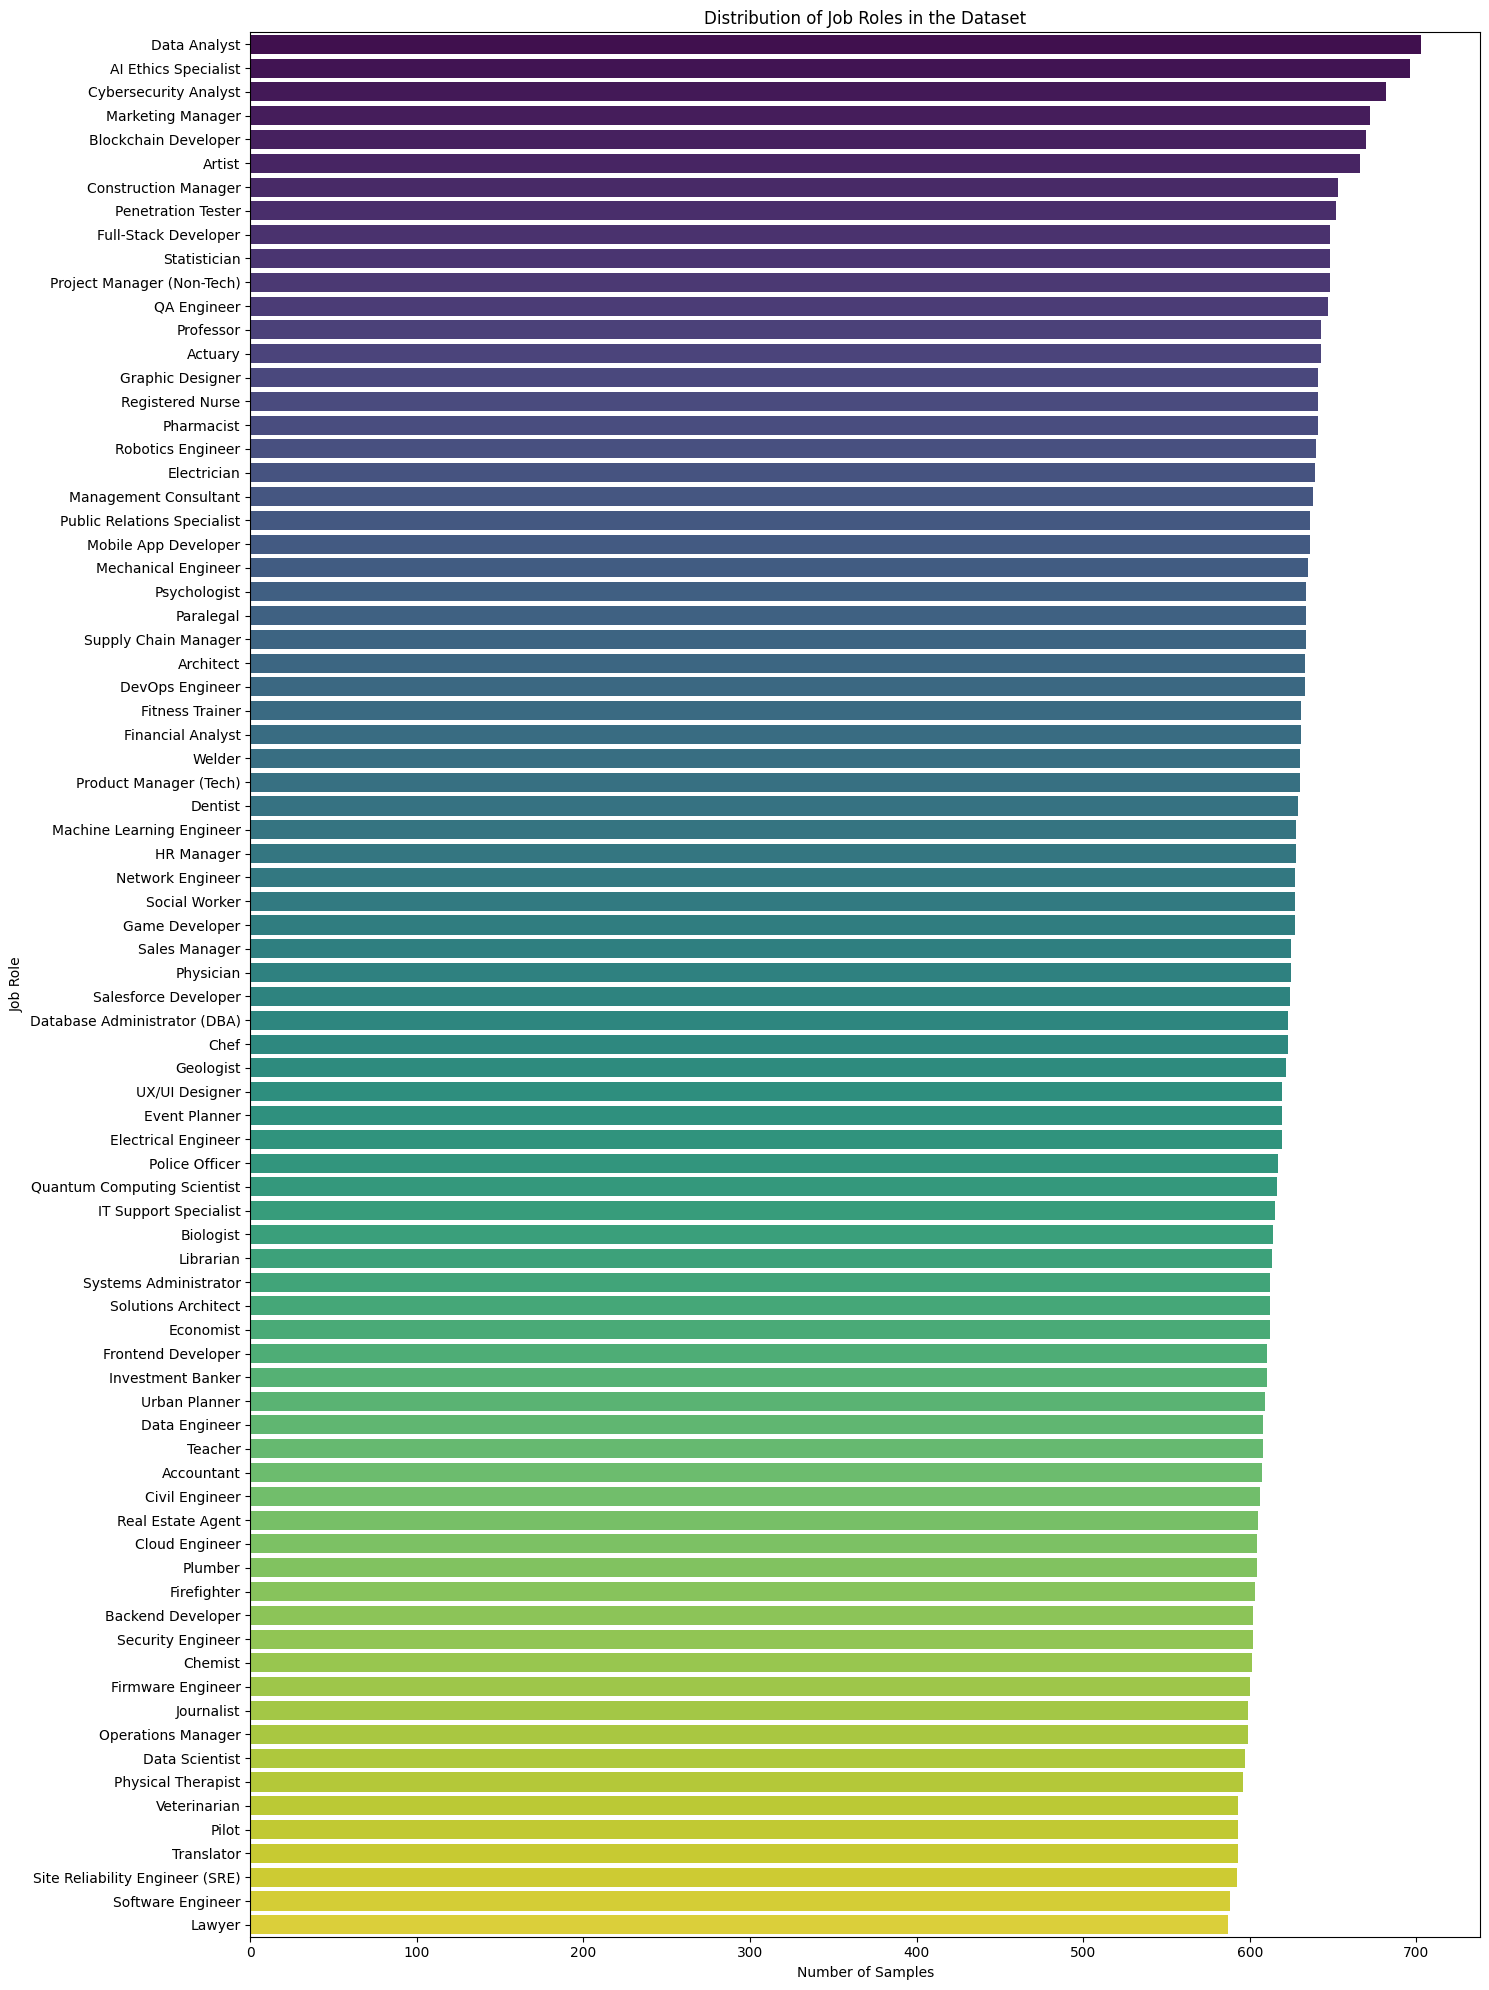

✅ The dataset is reasonably well-balanced across all job roles.


In [4]:
# --- 3.2 Class Distribution Analysis ---
print("\n--- Class Distribution Analysis ---")
plt.figure(figsize=(15, 20))
sns.countplot(y=df['Job_Role'], order = df['Job_Role'].value_counts().index, palette='viridis')
plt.title('Distribution of Job Roles in the Dataset')
plt.xlabel('Number of Samples')
plt.ylabel('Job Role')
plt.tight_layout()
plt.show()

role_counts = df['Job_Role'].value_counts()
if (role_counts.max() / role_counts.min()) < 1.2:
    print("✅ The dataset is reasonably well-balanced across all job roles.")
else:
    print("Note: There is a notable imbalance in the class distribution.")

 We separate our features (X) from our new encoded target (y).

In [5]:
# --- Define Features (X) and Target (y) ---
X = df.drop(['Job_Role', 'Job_Role_Encoded'], axis=1)
y = df['Job_Role_Encoded'] # Use the encoded column for training

feature_list = list(X.columns)

# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")


Training set size: 40000 samples
Testing set size: 10000 samples



 ## 4. Exhaustive Hyperparameter Tuning for XGBoost
 
 This is the most computationally intensive step. We are giving `GridSearchCV` a wide range of parameters to test with 10-fold cross-validation to find the optimal model configuration.



In [6]:
# --- Define the parameter grid for XGBoost ---
# This grid is slightly adjusted for GPU training efficiency
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

In [7]:
# --- Initialize the GridSearchCV object for GPU ---
# **THE KEY CHANGE IS HERE**: We add device="cuda"
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob', 
        eval_metric='mlogloss', 
        use_label_encoder=False, 
        random_state=42,
        device="cuda"  # This tells XGBoost to use the GPU
    ),
    param_grid=param_grid,
    cv=10,
    n_jobs=16, # Still use CPU cores for data handling
    verbose=3
)

print("Starting GPU-accelerated hyperparameter tuning with XGBoost...")
grid_search.fit(X_train, y_train) 
print("Hyperparameter tuning complete.")

# --- Get the best parameters ---
best_params = grid_search.best_params_
print(f"\nBest parameters found: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Starting GPU-accelerated hyperparameter tuning with XGBoost...
Fitting 10 folds for each of 8 candidates, totalling 80 fits


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:11:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hyperparameter tuning complete.

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9639



## 5. Train and Evaluate the Final XGBoost Model
 
 We will now train a new model using the best parameters found by the grid search and evaluate it on our unseen test set.



In [8]:
# --- Initialize and Train the Final Model ---
print("Training the final XGBoost model with the best parameters...")
final_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)

final_model.fit(X_train, y_train)
print("Final model training complete.")

Training the final XGBoost model with the best parameters...


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:12:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final model training complete.


We will now visualize and test the model accuracy

In [9]:
# --- Make predictions and evaluate ---
y_pred_encoded = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"\nFinal XGBoost Model Accuracy: {accuracy:.4f}")

# --- Display the Classification Report ---
# We need to convert the encoded labels back to original job roles for the report
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_encoded)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))




Final XGBoost Model Accuracy: 0.9632

Classification Report:
                                 precision    recall  f1-score   support

           AI Ethics Specialist       1.00      1.00      1.00       139
                     Accountant       1.00      1.00      1.00       121
                        Actuary       1.00      1.00      1.00       129
                      Architect       1.00      1.00      1.00       127
                         Artist       1.00      1.00      1.00       133
              Backend Developer       1.00      1.00      1.00       120
                      Biologist       1.00      1.00      1.00       123
           Blockchain Developer       1.00      1.00      1.00       134
                           Chef       1.00      1.00      1.00       125
                        Chemist       1.00      1.00      1.00       120
                 Civil Engineer       1.00      1.00      1.00       121
                 Cloud Engineer       1.00      1.00      1.0

In [10]:
# --- Enhanced Confusion Matrix ---
print("\n--- Detailed Confusion Matrix ---")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)


--- Detailed Confusion Matrix ---


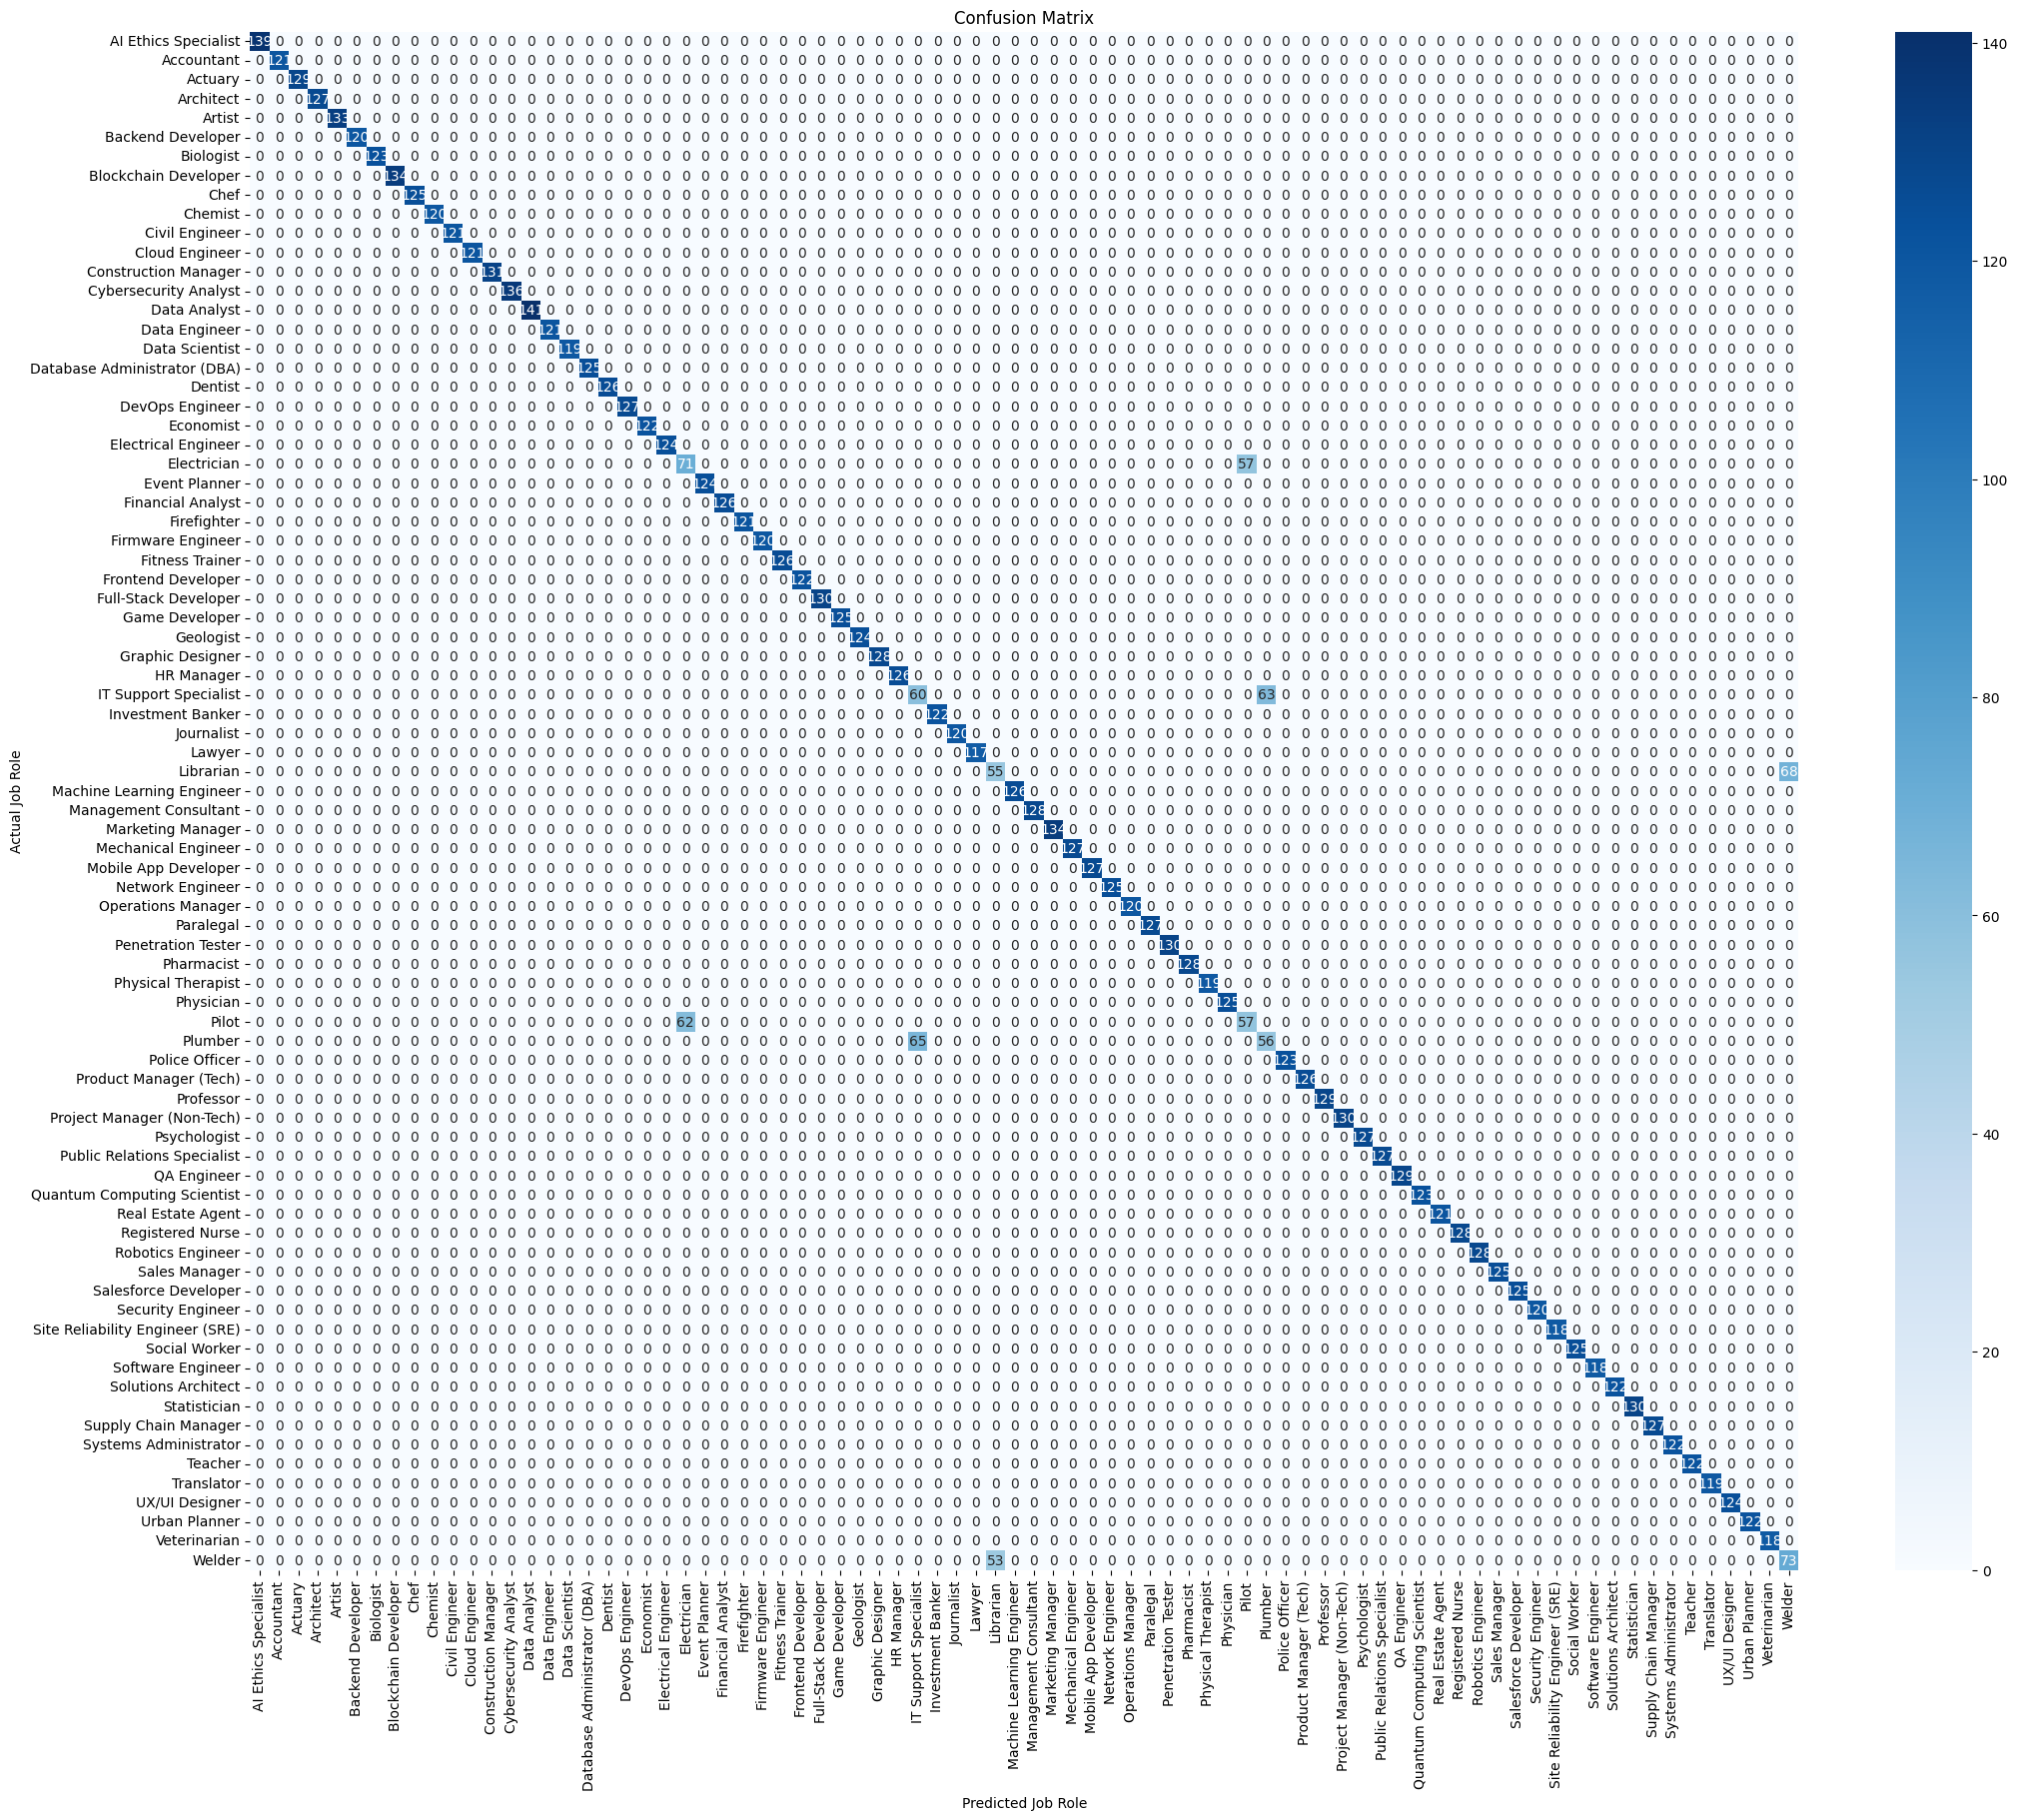

In [11]:
# Plotting the heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Job Role')
plt.xlabel('Predicted Job Role')
plt.show()

In [12]:
# --- Manual Sanity Checks ---
print("\n--- Manual Sanity Checks ---")
def test_hypothetical_profile(skills_dict):
    # Create a single-row DataFrame with all model features, initialized to 0
    profile = pd.DataFrame(columns=feature_list)
    profile.loc[0] = 0.0
    
    # Set the weights for the skills provided
    for skill, weight in skills_dict.items():
        if skill in profile.columns:
            profile.at[0, skill] = weight
    
    # Make prediction
    prediction_encoded = final_model.predict(profile)[0]
    prediction_proba = final_model.predict_proba(profile)[0]
    
    predicted_role = le.inverse_transform([prediction_encoded])[0]
    confidence = prediction_proba[prediction_encoded]
    
    print(f"Profile Skills: {list(skills_dict.keys())}")
    print(f"✅ Top Prediction: '{predicted_role}' with {confidence:.2%} confidence.\n")


--- Manual Sanity Checks ---


In [13]:
# Test Case 1: Clear Civil Engineer
test_hypothetical_profile({
    'Civil Engineering': 0.9, 'AutoCAD': 0.95, 'Structural Engineering': 0.8, 'Revit': 0.7, 'Problem-Solving': 0.2
})

Profile Skills: ['Civil Engineering', 'AutoCAD', 'Structural Engineering', 'Revit', 'Problem-Solving']
✅ Top Prediction: 'Civil Engineer' with 99.94% confidence.



In [14]:
# Test Case 2: Ambiguous Role - Lawyer with Project Management skills
test_hypothetical_profile({
    'Litigation': 0.9, 'Contract Law': 0.85, 'Legal Research': 0.8, 'Project Management': 0.6, 'Communication': 0.3
})

Profile Skills: ['Litigation', 'Contract Law', 'Legal Research', 'Project Management', 'Communication']
✅ Top Prediction: 'Lawyer' with 99.79% confidence.




## 6. Save the Final Model, Feature List, and Label Encoder
 
 We need to save the `LabelEncoder` as well, so our API can convert the numeric predictions back into job role names.



In [15]:

# --- Create a directory to save the model ---
MODEL_DIR = 'saved_model_xgboost2'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# --- Define file paths ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_PATH = os.path.join(MODEL_DIR, f'xgb_job_predictor_{timestamp}.joblib')
FEATURES_PATH = os.path.join(MODEL_DIR, f'xgb_feature_list_{timestamp}.joblib')
ENCODER_PATH = os.path.join(MODEL_DIR, f'xgb_label_encoder_{timestamp}.joblib')

# --- Save the files ---
joblib.dump(final_model, MODEL_PATH)
joblib.dump(feature_list, FEATURES_PATH)
joblib.dump(le, ENCODER_PATH)

print(f"Optimized XGBoost model saved to: {MODEL_PATH}")
print(f"Feature list saved to: {FEATURES_PATH}")
print(f"Label encoder saved to: {ENCODER_PATH}")
print("\nSetup complete! The new model is ready.")


Optimized XGBoost model saved to: saved_model_xgboost2\xgb_job_predictor_20250717_231408.joblib
Feature list saved to: saved_model_xgboost2\xgb_feature_list_20250717_231408.joblib
Label encoder saved to: saved_model_xgboost2\xgb_label_encoder_20250717_231408.joblib

Setup complete! The new model is ready.
